In [1]:
# importa os pacotes necessários
import numpy as np
import os, cv2, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 


from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import  cross_val_score


from skimage.feature import greycomatrix, greycoprops
from skimage.feature import hog

In [2]:
#funções de leitura e preparação das imagens
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))    
    return data

def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
# dois exemplos de descritores. Você deve criar outros mais robustos.
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):     
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    #image = cv2.imread(image_file)        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [3]:
TRAIN_DIR = 'kaggle/train/'
print(os.listdir('kaggle/train'))
ROWS = 128
COLS = 128
CHANNELS = 3
NIM = 1000

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] #full dataset: dogs and cats
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

# considera apenas NIM imagens. Para o dataset completo, desconsiderar.
train_images = train_dogs[:NIM] + train_cats[:NIM]
print(len(train_images))
print(len(train_dogs))
print(len(train_cats))

random.shuffle(train_images)

# Leitura das imagens
train = prep_data(train_images)
print("Train shape: {}".format(train.shape))

# Cria os labels (rótulos)
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)


['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg', 'cat.10005.jpg', 'cat.10006.jpg', 'cat.10007.jpg', 'cat.10008.jpg', 'cat.10009.jpg', 'cat.1001.jpg', 'cat.10010.jpg', 'cat.10011.jpg', 'cat.10012.jpg', 'cat.10013.jpg', 'cat.10014.jpg', 'cat.10015.jpg', 'cat.10016.jpg', 'cat.10017.jpg', 'cat.10018.jpg', 'cat.10019.jpg', 'cat.1002.jpg', 'cat.10020.jpg', 'cat.10021.jpg', 'cat.10022.jpg', 'cat.10023.jpg', 'cat.10024.jpg', 'cat.10025.jpg', 'cat.10026.jpg', 'cat.10027.jpg', 'cat.10028.jpg', 'cat.10029.jpg', 'cat.1003.jpg', 'cat.10030.jpg', 'cat.10031.jpg', 'cat.10032.jpg', 'cat.10033.jpg', 'cat.10034.jpg', 'cat.10035.jpg', 'cat.10036.jpg', 'cat.10037.jpg', 'cat.10038.jpg', 'cat.10039.jpg', 'cat.1004.jpg', 'cat.10040.jpg', 'cat.10041.jpg', 'cat.10042.jpg', 'cat.10043.jpg', 'cat.10044.jpg', 'cat.10045.jpg', 'cat.10046.jpg', 'cat.10047.jpg', 'cat.10048.jpg', 'cat.10049.jpg', 'cat.1005.jpg'

Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Train shape: (2000, 3, 128, 128)


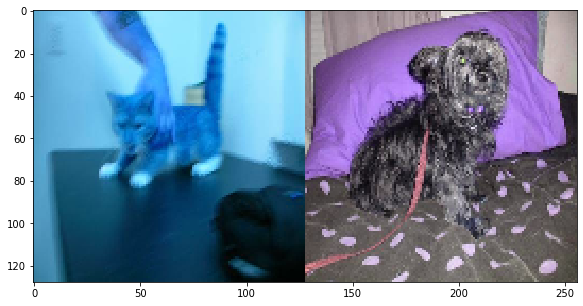

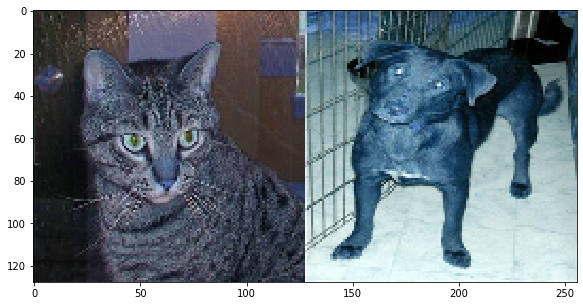

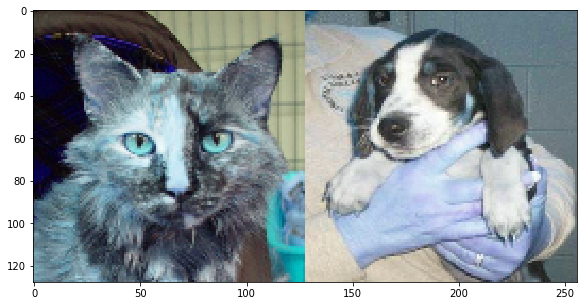

In [4]:
for idx in range(0,3):
    show_cats_and_dogs(idx)

In [5]:
rawImages = []
descHist = []

count = len(train_images)

for i, image_file in enumerate(train_images):
    image = read_image(image_file)
    pixels = image_to_feature_vector(image)
    histogram = extract_color_histogram(image)
    
    rawImages.append(pixels)
    descHist.append(histogram)
        
    if i%250 == 0: print('Processed {} of {}'.format(i, count))

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000


In [12]:
print(len(rawImages[0]))

3072


In [6]:
#Avalia o primeiro descritor: as imagens raw

(X_train, X_test, y_train, y_test) = train_test_split(rawImages, labels, test_size=0.25, random_state=42)

classifiers = [
    KNeighborsClassifier(17),    
    DecisionTreeClassifier(),
    GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100))    

KNeighborsClassifier
****Results****
accuracy: 53.20%
DecisionTreeClassifier
****Results****
accuracy: 54.40%
GaussianNB
****Results****
accuracy: 58.40%


In [7]:
#Avalia o segundo descritor: color histogram

(X_train, X_test, y_train, y_test) = train_test_split(
    descHist, labels, test_size=0.25, random_state=42)

classifiers = [
    KNeighborsClassifier(17),    
    DecisionTreeClassifier(),
    GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100))   

KNeighborsClassifier
****Results****
accuracy: 58.60%
DecisionTreeClassifier
****Results****
accuracy: 61.20%
GaussianNB
****Results****
accuracy: 58.80%


In [8]:
#Avalia a combinação dos dois primeiros descritores!

#ATENÇÃO: ESTE É APENAS UM CÓDIGO EXEMPLO. VOCÊ DEVE DESENVOLVER
#DESCRITORES MAIS ROBUSTOS, BEM COMO EXPLORAR MELHOR AS MÉTRICAS
#DE AVALIAÇÃO (MATRIZ DE CONFUSÃO, ETC)

trainAux = np.hstack((descHist, rawImages))
(X_train, X_test, y_train, y_test) = train_test_split(
    trainAux, labels, test_size=0.25, random_state=42)

classifiers = [
    KNeighborsClassifier(17),    
    DecisionTreeClassifier(),
    GaussianNB()]

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = clf.score(X_test, y_test)
    print("accuracy: {:.2f}%".format(acc * 100))   

KNeighborsClassifier
****Results****
accuracy: 53.20%
DecisionTreeClassifier
****Results****
accuracy: 58.40%
GaussianNB
****Results****
accuracy: 61.20%
